In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator


In [2]:

# Create a Spark session
spark = SparkSession.builder.appName("CountryClassification").getOrCreate()


In [3]:
# Load your dataset (replace 'your_data_path' with the actual path)
dataset_path = (r"C:\Users\sanja\Desktop\Big Data\World Energy Consumption.csv")

data = spark.read.csv(dataset_path, header=True, inferSchema=True)

data.select('primary_energy_consumption').summary().show()


+-------+--------------------------+
|summary|primary_energy_consumption|
+-------+--------------------------+
|  count|                     10134|
|   mean|        1672.2461857114647|
| stddev|         8827.069144835215|
|    min|                       0.0|
|    25%|                     7.513|
|    50%|                    67.159|
|    75%|                    388.84|
|    max|                 162194.29|
+-------+--------------------------+



In [4]:
threshold = 1672.2461857114647

In [5]:
# Create a new binary label column based on the threshold
data = data.withColumn("label", (data["primary_energy_consumption"] > threshold).cast("double"))


In [6]:
# Select relevant features (customize this based on your dataset)
feature_columns = ["coal_production", "gas_production", "oil_production", "renewables_electricity"]


In [7]:
# Create a feature vector using VectorAssembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid = "skip")
data = assembler.transform(data)


In [8]:
# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.7, 0.3], seed=4)


In [9]:
# Create and train a logistic regression model
lr = LogisticRegression(labelCol="label", featuresCol="features")
model = lr.fit(train_data)


In [10]:
# Make predictions on the test data
predictions = model.transform(test_data)


In [11]:
# Evaluate the model using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"Area under ROC: {auc}")


Area under ROC: 0.9928421344293333


In [12]:
feature_importance = model.coefficients
print("Feature Importance:")
for i, col_name in enumerate(feature_columns):
    print(f"{col_name}: {feature_importance[i]}")


Feature Importance:
coal_production: 0.0008327130335223676
gas_production: 0.004733352891113034
oil_production: 0.0012705127194636517
renewables_electricity: 0.02594979597543682


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import numpy as np

# Convert the label column in PySpark RDD to a Python list
y_true = [float(row.label) for row in predictions.select("label").collect()]

# Get the predicted probabilities as a list
y_scores = [float(row.probability[1]) for row in predictions.select("probability").collect()]



In [14]:
# Get the ROC curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)


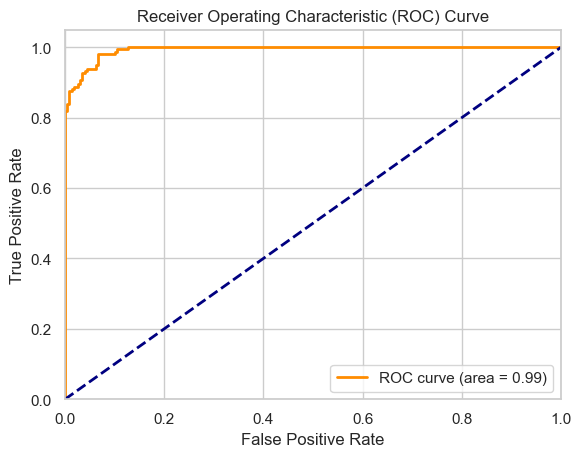

In [15]:
# Plot the ROC curve
plt.figure()
sns.set(style="whitegrid")
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [16]:
spark.stop()